In [1]:
# !pip install /home/Christoph/Documents/PublicRepos/AFC
# !pip install --upgrade pyomo

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import itertools
from time import time
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

# DOPER
from doper.data.tariff import get_e19_2020_tariff
from doper.examples import ts_inputs, default_parameter #example_inputs
from doper import DOPER, get_solver, get_root, standard_report
from doper.models.basemodel import base_model, default_output_list
# from doper.models.battery import add_battery
# from doper.example import parameter_add_battery, ts_inputs, default_parameter
# from doper.plotting import plot_dynamic
from doper.computetariff import compute_periods

# AFC
from afc.utility.weather import read_tmy3

try:
    root = os.path.dirname(os.path.abspath(__file__))
except:
    root = os.getcwd()

### Development

### optModel.py

In [3]:
from afc.optModel import control_model

### defaultConfig.py

In [4]:
from afc.defaultConfig import default_parameter

### utility/plotting.py

In [5]:
from afc.utility.plotting import plot_standard1

### Check Radiance

In [6]:
# config_path = os.path.join(root, 'resources', 'radiance', 'room.cfg')
weather_path = os.path.join(root, 'resources', 'weather', 'USA_CA_San.Francisco.Intl.AP.724940_TMY3.csv')
# filestruct = {}
# filestruct['resources'] = os.path.join(root, 'resources', 'radiance', 'BSDFs')
# filestruct['matrices'] = os.path.join(root, 'resources', 'radiance', 'matrices', 'ec', '0.6')
# forecaster = forecast.Forecast(config_path, regenerate=False, filestruct=filestruct)

from afc.radiance.configs import get_config
from afc.radiance.forecast import Forecast


wwr = 0.6 # [0.4, 0.6]
mode = 'ec' # ['shade', 'dshade', blinds', 'ec']
facade_type = 'ec' # ['shade', 'blinds', 'ec']
filestruct, config_path = get_config(mode, wwr, root=os.path.join(root, '..', 'afc', 'resources', 'radiance'))
forecaster = Forecast(config_path, facade_type=facade_type,
                      regenerate=False, filestruct=filestruct,
                      wpi_plot=False, wpi_loc='23back')



#data = example_inputs(parameter)
#data = example_inputs_laafb_report1(parameter)
#data = example_inputs(parameter, load='B90', scale_load=150, scale_pv=100)

# Run Radiance
weather, info = read_tmy3(weather_path)
weather = weather.resample('5T').interpolate()
st = weather.index[int(len(weather.index)/2)].date()

#parameter = dafault_parameter()
#parameter = dafault_parameter_laafb_report1()
parameter = default_parameter()

#'''
wf = weather.loc[st:st+pd.DateOffset(hours=24),]
data = forecaster.compute2(wf[['DNI','DHI']])

'''
# run for each 6 hours
data = pd.DataFrame()
sst = st
for i in range(4):
    wf = weather.loc[sst:sst+pd.DateOffset(hours=6),['DNI','DHI']]
    if data.empty:
        data = forecaster.compute2(wf)
    else:
        data = data.append(forecaster.compute2(wf))
    sst += pd.DateOffset(hours=6, minutes=1)
'''
data, parameter = compute_periods(data, get_e19_2020_tariff(), parameter)
#parameter['tariff'].update(tariff)
data['oat'] = wf['DryBulb']
data['wind_speed'] = wf['Wspd']

# Example for facade
b = 0
data['battery_{!s}_avail'.format(b)] = 0
data['battery_{!s}_demand'.format(b)] = 0
data['battery_reg'] = 0
data['wpi_min'] = 500
data['glare_max'] = 0.4
data['generation_pv'] = 0
data['load_demand'] = 0
data['temp_room_max'] = 24
data['temp_room_min'] = 20
data['temp_slab_max'] = 23
data['temp_slab_min'] = 21
data['temp_wall_max'] = 1e6
data['temp_wall_min'] = -1e6
#data['plugload'] = 10 # W
#data['occupant_load'] = 15 # W
data['plug_load'] = 50 # W
data['occupant_load'] = 0 # W
data['equipment'] = 100 # W
data['occupancy_light'] = 0.5 # 50 % occupancy

# Resmaple to 5 min
if False:
    data = data.resample('5T').asfreq()
    for c in data.columns:
        if c in ['load_demand','generation_pv','oat']:
            data[c] = data[c].interpolate()
        else:
            data[c] = data[c].ffill()

In [7]:
# # data = pd.read_csv('testing/error_controller_inputs.csv', index_col=[0])
# # data.index = pd.to_datetime(data.index)
# # wf = weather.loc[data.index[0]:data.index[-1],]
# # #parameter['zone']['temps_initial'] = [21.04609822335874, 21.780308212918612]

# resdir = '/home/christoph/Documents/DynamicFacades/Results'
# #fname = '2017-06-0409:30:00'
# fname = '2017-07-04015500'
# fname = os.path.join(resdir, fname)
# data = pd.read_csv(fname+'.csv', index_col=[0])
# data.index = pd.to_datetime(data.index)
# wf = weather.loc[data.index[0]:data.index[-1],]
# import json
# with open(fname+'.txt', 'r') as f:
#     parameter = json.loads(f.read())
# parameter['tariff']['energy'] = {int(k):v for k,v in parameter['tariff']['energy'].items()}
# parameter['tariff']['demand'] = {int(k):v for k,v in parameter['tariff']['demand'].items()}
# parameter['tariff']['export'] = {int(k):v for k,v in parameter['tariff']['export'].items()}
# parameter['site']['demand_periods_prev'] = {int(k):v for k,v in parameter['site']['demand_periods_prev'].items()}

In [8]:
# print('INFO: Recovering full Radiance.')
# t = forecaster.compute2(data[['DNI','DHI']])
# #print(t[[c for c in t.columns if 'wpi' in c]].loc['2017-07-04 15:00':'2017-07-04 16:00']) #.plot(legend=False)
# for c in t.columns:
#     data[c] = t[c].round(6)
# #print(data[[c for c in data.columns if 'wpi' in c]].loc['2017-07-04 15:00':'2017-07-04 16:00']) #.plot(legend=False)

In [9]:
# parameter['battery']['power_charge'] = [0]
# parameter['battery']['power_discharge'] = [0]

### Check Rounding Cutoffs

In [10]:
if False:
    stats = data.describe().transpose()
    stats[(stats['std']>0) & ((stats['mean'] < 1e-1) | (stats['std'] < 1e-1))]

### Check Radiance Cutoffs

In [11]:
if False:
    rad_cutoff = parameter['facade']['rad_cutoff']
    n = len(rad_cutoff.keys())
    fig, axs = plt.subplots(n,1, figsize=(12, n*3), sharex=True, sharey=False)
    axs = axs.ravel()
    i = 0
    for k in rad_cutoff.keys():
        for c in data.columns:
            if k in c:
                data[c].plot(ax=axs[i])
                t = data[c].mask(data[c] < rad_cutoff[k][0], 0).copy()
                t.mask(t > rad_cutoff[k][1], rad_cutoff[k][1]).plot(ax=axs[i], title=k)
        i += 1
    plt.show()

### Run Optimization

In [12]:
# parameter['zone']['view_scale'] = 0.5 # 0.2
parameter['objective']['weight_view'] = 0
parameter['objective']['weight_actuation'] = 0.01

In [13]:
parameter['facade']['rad_cutoff']

{'wpi': [5, 1000000.0],
 'ev': [250, 1000000.0],
 'shg': [0, 1000000.0],
 'abs1': [50, 1000000.0],
 'abs2': [5, 1000000.0],
 'tsol': [5, 1000000.0],
 'iflr': [5, 1000000.0]}

In [14]:
parameter['facade']['rad_cutoff']['shg'] = [1e3, 1e3]
t = data[[c for c in data.columns if 'wpi' in c]].copy(deep=True)

In [15]:
if not 'regulation_reserved_battery' in parameter['site'].keys():
    parameter['site']['regulation_reserved_battery'] = False
if not 'regulation_reserved_variable_battery' in parameter['site'].keys():
    parameter['site']['regulation_reserved_variable_battery'] = False
if not 'regulation_xor' in parameter['site'].keys():
    parameter['site']['regulation_xor'] = False
if not 'regulation_xor_building' in parameter['site'].keys():
    parameter['site']['regulation_xor_building'] = False
if not 'regulation_all' in parameter['site'].keys():
    parameter['site']['regulation_all'] = False
if not 'regulation_min' in parameter['site'].keys():
    parameter['site']['regulation_min'] = False
if not 'regulation_symmetric' in parameter['site'].keys():
    parameter['site']['regulation_symmetric'] = False


In [16]:
from doper import resample_variable_ts
import logging
import time

# New Radiance cutoff
rad_cutoff = parameter['facade']['rad_cutoff']
for k in rad_cutoff.keys():
    for c in data.columns:
        if k in c:
            data.loc[:,c] = data[c].mask(data[c] < rad_cutoff[k][0], 0)
            data.loc[:,c] = data[c].mask(data[c] > rad_cutoff[k][1], rad_cutoff[k][1])

solver_path = get_solver('cbc')
output_list = default_output_list(parameter)
#solver_path = '/home/christoph/Documents/test_cbc/Cbc-2.9.9/bin/cbc'
smartDER = DOPER(model=control_model,
                 parameter=parameter,
                 #solver_path=os.path.join(solver_dir, 'glpk_64', 'glpsol.exe'),
                 #solver_path=get_solver('couenne', solver_dir=solver_dir),
                 solver_path=solver_path,
                 output_list=output_list)

# Note seconds = 15 s + threads x time
options = {'seconds': int(5*60), 'maxIterations': int(1e6), 
           'threads': int(1), 'slog': 0, 'log': 0} #, 'dualT': 1e-7, 'dualB': 1e7}

#res = smartDER.do_optimization(data, tee=False, options=options)

test = resample_variable_ts(data.copy(deep=True), reduced_start=6*60, reduced_ts=60, cols_fill=[])
test, _ = compute_periods(test, get_e19_2020_tariff(), parameter)

res = smartDER.do_optimization(test, tee=False, options=options)
duration, objective, df, model, result, termination, parameter = res
print(standard_report(res))
print('Zone actuation cost:', round(model.sum_zone_actuation.value, 1))
print('Zone glare cost:', round(model.sum_glare_penalty.value, 1))
print('Zone view cost:', round(model.sum_view_penalty.value, 1))
#plot_battery1(df, model)

Duration [s]		1.34
Objective [$]		10.59			3.7 (Total Cost)
Cost [$]		7.15 (Energy)	3.38 (Demand)
CO2 Emissions [kg]		0.0

Zone actuation cost: 6.0
Zone glare cost: 4.0
Zone view cost: 2.9


### Variable Timestep

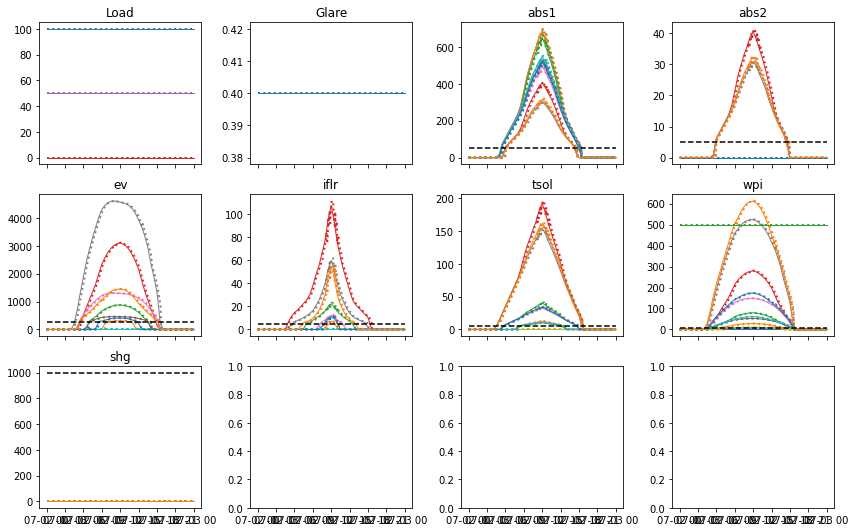

In [17]:
test = resample_variable_ts(data.copy(deep=True), reduced_start=60, reduced_ts=30, cols_fill=[])

cols = []
#cols.append(['DHI','DNI'])
#cols.append(['DryBulb','oat','temp_room_max','temp_room_min',
#             'temp_slab_max','temp_slab_min'])
#cols.append(['battery_0_avail','battery_0_demand','battery_reg'])
cols.append(['equipment','generation_pv','load_demand','occupant_load','plug_load'])
cols.append(['glare_max'])
cols.append([c for c in data.columns if 'abs1' in c])
cols.append([c for c in data.columns if 'abs2' in c])
cols.append([c for c in data.columns if 'ev' in c])
cols.append([c for c in data.columns if 'iflr' in c])
cols.append([c for c in data.columns if 'tsol' in c])
cols.append([c for c in data.columns if 'wpi' in c])
cols.append([c for c in data.columns if 'shg' in c])
#title = ['Solar','Temperature','Battery']
title = []
title += ['Load','Glare','abs1','abs2','ev','iflr','tsol','wpi','shg']

rows = int(round(len(cols)/4 + 0.49))
fig, axs = plt.subplots(rows, 4, figsize=(12, rows*2.5), sharex=True, sharey=False)
axs = axs.ravel()
i = 0
for c in cols:
    ci = 0
    for k in c:
        axs[i].plot(data[k], color='C{}'.format(ci), linestyle=':', linewidth=2)
        axs[i].plot(test[k], color='C{}'.format(ci), linestyle='-', linewidth=1)
        ci += 1
    if title[i] in parameter['facade']['rad_cutoff'].keys():
        axs[i].plot(test.index, [parameter['facade']['rad_cutoff'][title[i]][0]]*len(test),
                    color='black', linestyle='--')
    axs[i].set_title(title[i])
    i += 1
plt.tight_layout()
plt.show()

In [18]:
var_ts = pd.DataFrame([(24, 5)]+list(itertools.product(range(0, 12+2, 2), [15, 30, 60])),
                      columns=['reduced_start','reduced_ts'])
smartDER = DOPER(model=control_model,
                 parameter=parameter,
                 solver_path=solver_path,
                 pyomo_logger=logging.ERROR,
                 output_list=output_list)
for ix in var_ts.index:
    test = resample_variable_ts(data.copy(deep=True),
                                reduced_start=int(var_ts.loc[ix,'reduced_start']*60),
                                reduced_ts=int(var_ts.loc[ix,'reduced_ts']), cols_fill=[])
    test, _ = compute_periods(test, get_e19_2020_tariff(), parameter)
    options = {'seconds': int(1*60)}
    res = smartDER.do_optimization(test, tee=False, options=options, print_error=False)
    duration, objective, df, model, result, termination, parameter = res
    var_ts.loc[ix, 'duration'] = duration
    var_ts.loc[ix, 'energy'] = model.sum_energy_cost.value * parameter['objective']['weight_energy']
    var_ts.loc[ix, 'demand'] = model.sum_demand_cost.value * parameter['objective']['weight_demand']

In [19]:
var_ts

,reduced_start,reduced_ts,duration,energy,demand
0,24,5,60.665132,7.472043,3.376
1,0,15,17.499989,7.409819,3.376
2,0,30,2.210824,7.317431,3.376
3,0,60,1.149160,7.150559,3.376
4,2,15,12.279386,7.409840,3.376
5,2,30,3.281342,7.317483,3.376
6,2,60,0.934970,7.150672,3.376
7,4,15,24.275187,7.409860,3.376
8,4,30,3.608032,7.317534,3.376
9,4,60,0.762179,7.150782,3.376
